<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/movieLens_average/ave_movie_RSCCMM_CF_delta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

movieLens_average/ave_movie_RSCCMM_CF.ipynb

In [1]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv

In [ ]:
data_training = pd.read_excel('data_training.xlsx',index_col=0)
data_test = pd.read_excel('data_test.xlsx',index_col=0)

X = data_training.values[:, 1:]
TEST = data_test.values

print(X.shape)
print(TEST.shape)

(943, 1682)
(10000, 3)


In [ ]:
# 未評価値を各ユーザーの平均評価値で補完
ave = np.empty((X.shape[0]))
for n in range(X.shape[0]):
    n_sum = 0
    for m in range(X.shape[1]):
        n_sum += X[n][m]
    if n_sum == 0:
        ave[n] = 0
    else:
        ave[n] = n_sum/np.count_nonzero(X,axis=1)[n]

X_movie = np.asarray(X, dtype = "float")

for n in range(X.shape[0]):
  for m in range(X.shape[1]):
    if X[n][m] == 0 :
      X_movie[n][m] = ave[n]

print(X_movie)

[[5.         3.         4.         ... 3.61065574 3.61065574 3.61065574]
 [4.         3.75438596 3.75438596 ... 3.75438596 3.75438596 3.75438596]
 [2.80392157 2.80392157 2.80392157 ... 2.80392157 2.80392157 2.80392157]
 ...
 [5.         4.04761905 4.04761905 ... 4.04761905 4.04761905 4.04761905]
 [4.27027027 4.27027027 4.27027027 ... 4.27027027 4.27027027 4.27027027]
 [3.42361111 5.         3.42361111 ... 3.42361111 3.42361111 3.42361111]]


In [ ]:
#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u

In [ ]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_AVE(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, rough_u = RSCCMM(X, C, delta)
    # print(f"各クラスターの要素数: {np.sum(rough_u, axis=1)}")

    n_overlaps = np.sum((np.sum(rough_u, axis=0) > 1).astype(np.float64))
    # print(f"オーバーラップしている要素の数: {n_overlaps}")
    # print(f"オーバーラップしていない要素の数: {X.shape[0] - n_overlaps}")

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score)
    auc_sum += auc

  return auc_sum/roop

print(RSCCMM_CF_AUC_AVE(1, TEST, X_movie, 5, -7.428))

0.7045006661033423


delta_list:  [-7.428 -7.429 -7.43  -7.431 -7.432 -7.433 -7.434 -7.435 -7.436 -7.437]
C_list:  [7, 5, 3]


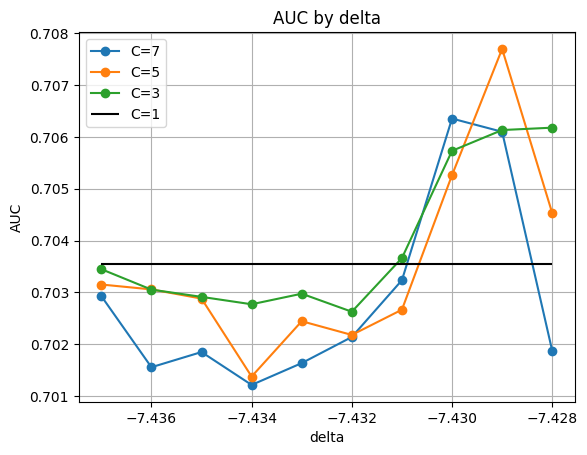

In [ ]:
#deltaのリスト
name = "ave_movie_RSCCMM_delta"
delta_list = np.arange(-7.428, -7.438, -0.001)
print("delta_list: ", delta_list)

#Cのリスト
C = [7, 5, 3]
print("C_list: ", C)

# csv output
output = [delta_list.tolist()]
output_info = [["クラスター数", "delta", "AUC"]]

for c in C:
  #aucのリスト
  auc_list = []

  for delta in delta_list:
    auc = RSCCMM_CF_AUC_AVE(10, TEST, X_movie, c, delta)
    output_info.append([c, delta, auc])
    # print(f"cluster{c}, delta={delta}, auc={auc}")
    auc_list.append(auc)
  plt.plot(delta_list, auc_list, marker = 'o', label=f"C={c}")
  output.append(auc_list)

plt.hlines(0.70355, delta_list[0], delta_list[len(delta_list)-1], color="k", label="C=1")
plt.legend()
plt.title('AUC by delta')
plt.xlabel('delta')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)

with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)

[7, 5, 3]
[-7.428 -7.429 -7.43  -7.431 -7.432 -7.433 -7.434 -7.435 -7.436 -7.437]
[[0.7018729  0.7060979  0.70635292 0.70323571 0.70214022 0.7016369
  0.70121614 0.70185028 0.7015575  0.70292926]
 [0.70452953 0.70769588 0.70526177 0.70266706 0.70217999 0.70244473
  0.70137773 0.70288101 0.70305795 0.70315256]
 [0.70617731 0.70613141 0.70573077 0.70366317 0.70262757 0.70297538
  0.70277157 0.7029143  0.70305423 0.70344826]]


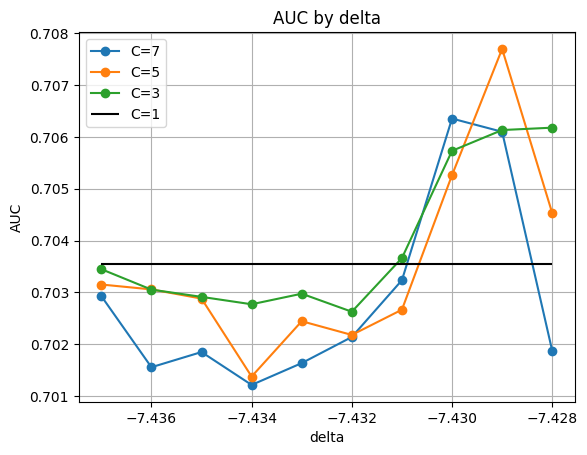

In [5]:
# csvデータから再現
name = "ave_movie_RSCCMM_delta"
input = pd.read_csv(f'{name}.csv', header=None)

input_x_delta = input.values[0] # deltaのリスト
input_y_auc = input.values[1:, :] # aucの結果(C, input_x_delta.length)

C = [7, 5, 3]
delta_list = np.arange(-7.428, -7.438, -0.001)
print(C) # csvに格納すると読み込みが難しいので，再現の時は確認する
print(input_x_delta)
print(input_y_auc)

for index, c in enumerate(C):
  plt.plot(input_x_delta, input_y_auc[index], marker = 'o', label=f"C={c}")


plt.hlines(0.70355, delta_list[0], delta_list[len(delta_list)-1], color="k", label="C=1")
plt.legend()
plt.title('AUC by delta')
plt.xlabel('delta')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

In [ ]:
# RCCMMのparams確認
#RCCMM
def RCCMM_CF(X, C, a, b):
  n, m = X.shape
  u = np.zeros((C,n))
  w = np.zeros((C,m))
  s = np.zeros((C,n))
  r = np.zeros((n,m))
  r_ = np.zeros((n,m))

  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  for step in range(100):
    u_old = u.copy()
    u = np.zeros((C,n))

    s = np.log(w) @ X.T

    s_max = s.max(0)
    u = (s >= a * s_max + b).astype(np.float64)
    u /= u.sum(0)

    w = (u @ X) + sys.float_info.epsilon
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(u - u_old).max() == 0:
      break

  if any(u.sum(1) == 0):
    raise Exception('要素数0のクラスター発生')

  r = u.T @ w
  r_ = u.T @ np.log(w)

  return r, r_

In [ ]:
#roopの回数を指定し、平均のaucを返す関数返す関数(RCCMM)
def RCCMM_CF_AUC_AVE(roop, test, X, C, alpha, beta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_sum = 0
  auc__sum = 0
  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)
  r__test_score = np.zeros(test_num)
  for i in range(test_num):
    test_true[i] = 1 if test[i][2] > 3 else 0

  for i in range(roop):
    r, r_ = RCCMM_CF(X, C, alpha, beta)

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]-1][test[j][1]-1]
      r__test_score[j] = r_[test[j][0]-1][test[j][1]-1]

    auc = roc_auc_score(test_true, r_test_score)
    auc_ = roc_auc_score(test_true, r__test_score)
    auc_sum += auc
    auc__sum += auc_

  return auc_sum/roop, auc__sum/roop

print(RCCMM_CF_AUC_AVE(10, TEST, X_movie, 30, 1.2, -5))

(0.7035475926295599, 0.7035483007981141)


beta_list:  [ 0.  -0.1 -0.2 -0.3 -0.4 -0.5 -0.6 -0.7 -0.8 -0.9]
C_list:  [7, 5, 3, 1]


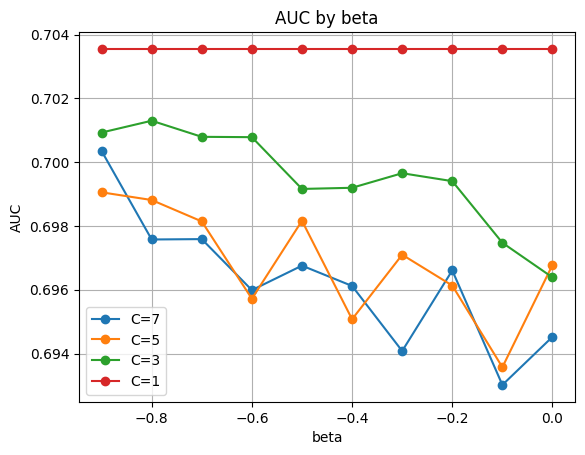

In [ ]:
#alphaのリスト
# name = "ave_movie_RCCMM_alpha"
name = "ave_movie_RCCMM_beta"
# alpha_list = np.arange(1.0, 1.00001, 0.000001)
# print("alpha_list: ", alpha_list)

beta_list = np.arange(0, -1, -0.1)
print("beta_list: ", beta_list)

#Cのリスト
C = [7, 5, 3, 1]
print("C_list: ", C)

# csv output
# output = [alpha_list.tolist()]
output = [beta_list.tolist()]
output_info = [["クラスター数", "beta", "AUC"]]

for c in C:
  #aucのリスト
  auc_list = []

  # for alpha in alpha_list:
  for beta in beta_list:
    auc, auc_ = RCCMM_CF_AUC_AVE(10, TEST, X_movie, c, 1, beta)
    output_info.append([c, beta, auc])
    # print(f"cluster{c}, beta={beta}, auc={auc}")
    auc_list.append(auc)
  plt.plot(beta_list, auc_list, marker = 'o', label=f"C={c}")
  output.append(auc_list)

# plt.hlines(0.70355, beta_list[0], beta_list[len(beta_list)-1], color="k", label="C=1")
plt.legend()
plt.title('AUC by beta')
plt.xlabel('beta')
plt.ylabel('AUC')
plt.grid(True)
plt.savefig(f"{name}.png", format="png", dpi=300)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)

with open(f'{name}_info.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output_info)

**結論: 未評価値をユーザーの平均評価値で補完したmovieLensでは、RCCMM-CFによる推薦性能の向上は見られない！**